In [1]:
import matplotlib.pyplot as plt

colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

# 예시:
# predicted와 example_output이 [1, 1, 30, 30] 크기의 텐서라고 가정
#show_grid_side_by_side(task_input, task_output, predicted)


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt


In [3]:

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = img_size // patch_size
        self.num_patches = self.grid_size ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.norm = nn.BatchNorm2d(embed_dim)  # LayerNorm 대신 BatchNorm2d 사용

    def forward(self, x):
        x = self.proj(x)
        x = self.norm(x)
        x = x.flatten(2)  # (B, E, P)
        x = x.transpose(1, 2)  # (B, P, E)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim=768, num_heads=12, mlp_dim=3072, dropout=0.1):
        super().__init__()
        self.layernorm1 = nn.LayerNorm(embed_dim)
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.layernorm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )
        self.layernorm3 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x_norm1 = self.layernorm1(x)
        attn_output, _ = self.attention(x_norm1, x_norm1, x_norm1)
        x = x + attn_output
        x = self.layernorm2(x)

        x_mlp_output = self.mlp(x)
        x = x + x_mlp_output
        x = self.layernorm3(x)
        return x

class ConvHead(nn.Module):
    def __init__(self, embed_dim=768, output_channels=11, output_size=30):
        super().__init__()
        self.conv = nn.Conv2d(embed_dim, output_channels, kernel_size=3, stride=1, padding=1)
        self.output_size = output_size

    def forward(self, x):
        B, P, E = x.shape
        H = W = int(P ** 0.5)  # Assumes square grid of patches
        x = x.transpose(1, 2).reshape(B, E, H, W)  # (B, E, H, W)
        x = self.conv(x)  # (B, output_channels, H, W)
        return nn.functional.interpolate(x, size=(self.output_size, self.output_size), mode='bilinear', align_corners=False)

class VisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768, num_heads=12, num_layers=12, output_channels=11, output_size=30, mlp_dim=3072, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        #self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.num_patches, embed_dim))
        self.pos_drop = nn.Dropout(p=dropout)
        self.transformer_encoders = nn.Sequential(
            *[TransformerEncoder(embed_dim, num_heads, mlp_dim, dropout) for _ in range(num_layers)]
        )
        self.norm = nn.LayerNorm(embed_dim)
        self.head = ConvHead(embed_dim, output_channels, output_size)

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        x = self.transformer_encoders(x)
        x = self.norm(x)
        x = x[:, 1:]  # Remove cls_token before passing to the head
        logits = self.head(x)
        return logits




In [4]:
# from thop import profile
# from thop import clever_format

# # 모델 생성 및 출력
# model_args =  {
#     "img_size": 30,
#     "patch_size": 3,
#     "in_channels": 1,
#     "embed_dim": 256,
#     "num_heads": 8,
#     "num_layers": 8,
#     "mlp_dim": 2048,
#     "dropout": 0.1,
#     "output_channels": 11,
# }

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = VisionTransformer(**model_args).to(device)

# # 입력 텐서 생성
# x = torch.randn(1, 1, 30, 30).to(device)

# # FLOPs 및 파라미터 수 계산
# try:
#     flops, params = profile(model, inputs=(x,))
#     flops, params = clever_format([flops, params], "%.3f")
#     print(f"FLOPs: {flops}")
#     print(f"파라미터 수: {params}")
# except Exception as e:
#     print(f"Error during profiling: {e}")
#     print(f"Input shape: {x.shape}")

In [5]:
# from bw_net_maml import BWNet_MAML

# model = BWNet_MAML(embed_size=1).to(device)

# # 입력 텐서 생성
# x = torch.randn(1, 1, 30, 30).to(device)

# # FLOPs 및 파라미터 수 계산
# try:
#     flops, params = profile(model, inputs=(x,))
#     flops, params = clever_format([flops, params], "%.3f")
#     print(f"FLOPs: {flops}")
#     print(f"파라미터 수: {params}")
# except Exception as e:
#     print(f"Error during profiling: {e}")
#     print(f"Input shape: {x.shape}")

Using cuda device
Epoch 1/500


Validation:  98%|█████████▊| 41/42 [08:08<00:11, 11.95s/it]

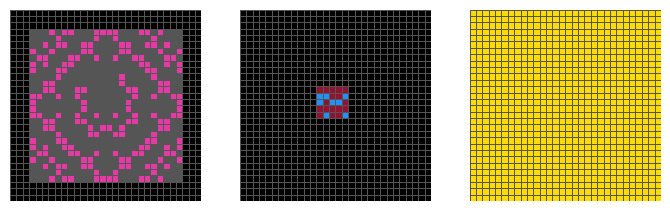

Validation: 100%|██████████| 42/42 [08:16<00:00, 11.81s/it]


Epoch 1/500, Loss: 7060.38525390625, Accuracy: 47.24908243929983%
Epoch 2/500


Validation:  98%|█████████▊| 41/42 [08:09<00:11, 11.92s/it]

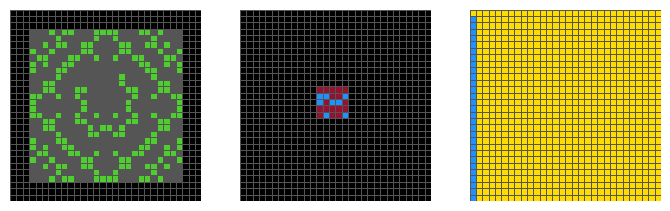

Validation: 100%|██████████| 42/42 [08:16<00:00, 11.82s/it]


Epoch 2/500, Loss: 7120.9404296875, Accuracy: 46.02096273291925%
Epoch 3/500


Validation:  98%|█████████▊| 41/42 [08:09<00:11, 11.94s/it]

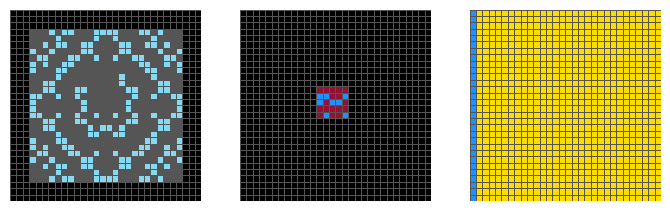

Validation: 100%|██████████| 42/42 [08:17<00:00, 11.84s/it]


Epoch 3/500, Loss: 7032.68896484375, Accuracy: 45.41749011857708%
Epoch 4/500


Validation:  98%|█████████▊| 41/42 [08:09<00:11, 11.93s/it]

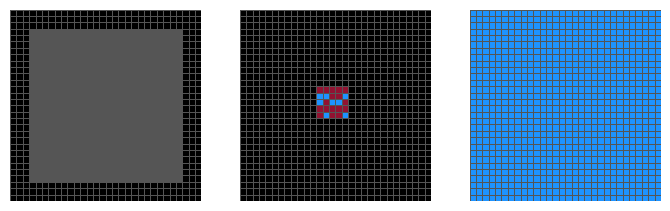

Validation: 100%|██████████| 42/42 [08:16<00:00, 11.83s/it]


Epoch 4/500, Loss: 7007.1748046875, Accuracy: 46.45680406549972%
Epoch 5/500


Validation:  98%|█████████▊| 41/42 [08:09<00:11, 11.92s/it]

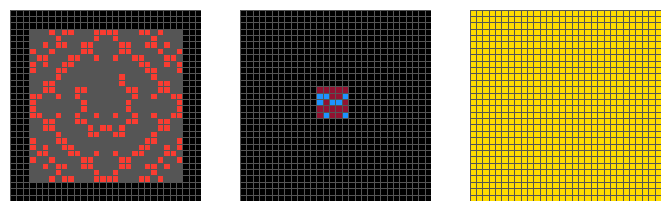

Validation: 100%|██████████| 42/42 [08:16<00:00, 11.82s/it]


Epoch 5/500, Loss: 7150.35791015625, Accuracy: 49.94353472614342%
Epoch 6/500


Validation:  98%|█████████▊| 41/42 [08:08<00:11, 11.92s/it]

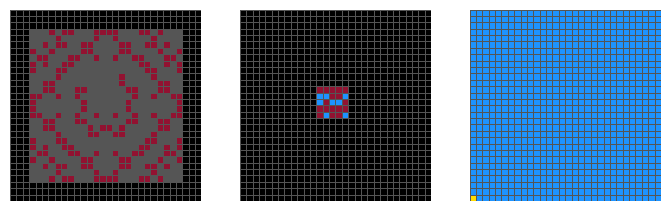

Validation: 100%|██████████| 42/42 [08:15<00:00, 11.81s/it]


Epoch 6/500, Loss: 7248.14208984375, Accuracy: 47.07615753811406%
Epoch 7/500


Validation:  98%|█████████▊| 41/42 [08:10<00:11, 11.96s/it]

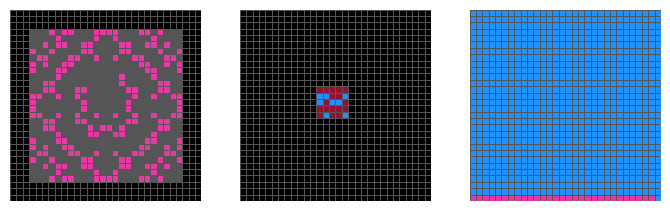

Validation: 100%|██████████| 42/42 [08:17<00:00, 11.85s/it]


Epoch 7/500, Loss: 7207.77685546875, Accuracy: 45.189864483342745%
Epoch 8/500


Validation:  98%|█████████▊| 41/42 [08:09<00:11, 11.97s/it]

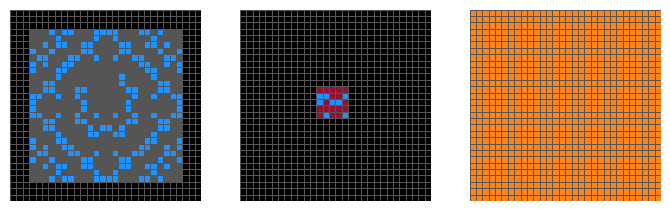

Validation: 100%|██████████| 42/42 [08:16<00:00, 11.83s/it]


Epoch 8/500, Loss: 6960.48388671875, Accuracy: 49.696499153020895%
Epoch 9/500


Validation:  98%|█████████▊| 41/42 [08:08<00:11, 11.90s/it]

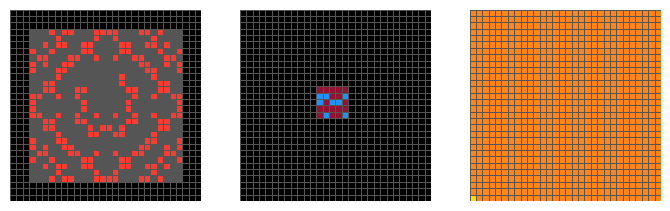

Validation: 100%|██████████| 42/42 [08:15<00:00, 11.81s/it]


Epoch 9/500, Loss: 7121.0595703125, Accuracy: 47.31613495200452%
Epoch 10/500


Validation:  98%|█████████▊| 41/42 [08:10<00:11, 11.95s/it]

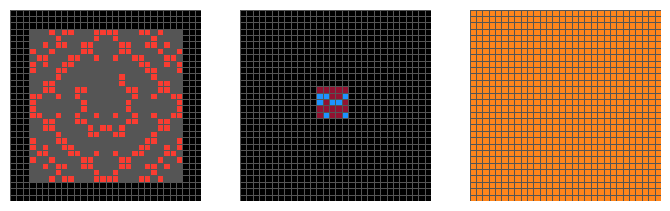

Validation: 100%|██████████| 42/42 [08:17<00:00, 11.85s/it]


Epoch 10/500, Loss: 7072.3232421875, Accuracy: 49.006564088085824%
Epoch 11/500


Validation:  98%|█████████▊| 41/42 [08:10<00:11, 11.99s/it]

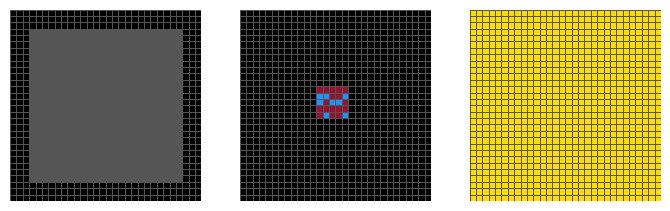

Validation: 100%|██████████| 42/42 [08:17<00:00, 11.84s/it]


Epoch 11/500, Loss: 6901.9951171875, Accuracy: 48.82128740824393%
Epoch 12/500


Validation:  98%|█████████▊| 41/42 [08:12<00:11, 11.97s/it]

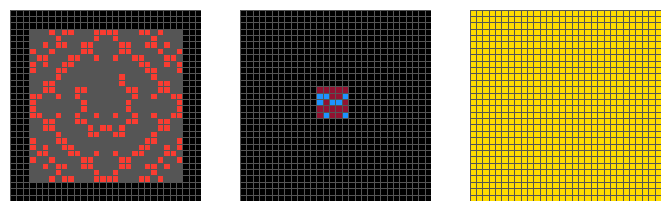

Validation: 100%|██████████| 42/42 [08:19<00:00, 11.90s/it]


Epoch 12/500, Loss: 7056.4873046875, Accuracy: 47.96019198193111%
Epoch 13/500


Validation:  98%|█████████▊| 41/42 [08:09<00:11, 11.93s/it]

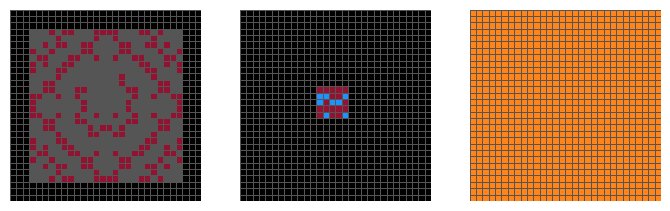

Validation: 100%|██████████| 42/42 [08:16<00:00, 11.83s/it]


Epoch 13/500, Loss: 7243.3037109375, Accuracy: 47.420242800677585%
Epoch 14/500


Validation:  98%|█████████▊| 41/42 [08:10<00:11, 11.96s/it]

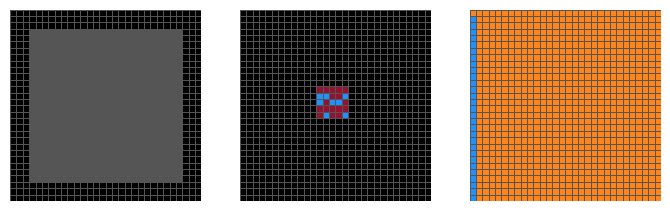

Validation: 100%|██████████| 42/42 [08:17<00:00, 11.84s/it]


Epoch 14/500, Loss: 7163.22021484375, Accuracy: 49.565923207227556%
Epoch 15/500


Validation:  98%|█████████▊| 41/42 [08:10<00:11, 11.96s/it]

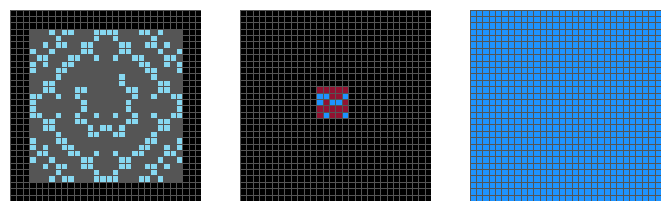

Validation: 100%|██████████| 42/42 [08:17<00:00, 11.86s/it]


Epoch 15/500, Loss: 6840.24658203125, Accuracy: 49.18478260869565%
Epoch 16/500


Validation:  98%|█████████▊| 41/42 [08:10<00:11, 11.97s/it]

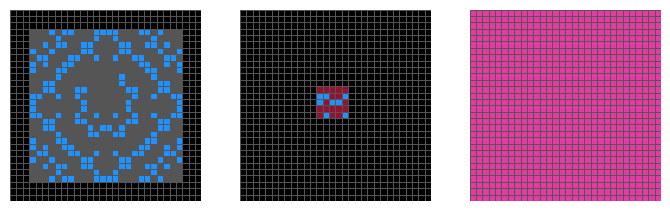

Validation: 100%|██████████| 42/42 [08:17<00:00, 11.85s/it]


Epoch 16/500, Loss: 7306.59130859375, Accuracy: 43.69529926595144%
Epoch 17/500


Validation:  98%|█████████▊| 41/42 [08:10<00:11, 11.95s/it]

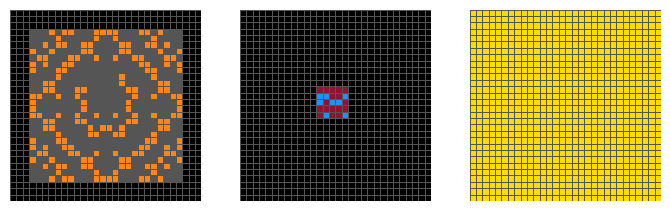

Validation: 100%|██████████| 42/42 [08:17<00:00, 11.84s/it]


Epoch 17/500, Loss: 7135.1962890625, Accuracy: 47.309076792772444%
Epoch 18/500


Validation:  98%|█████████▊| 41/42 [08:09<00:11, 11.96s/it]

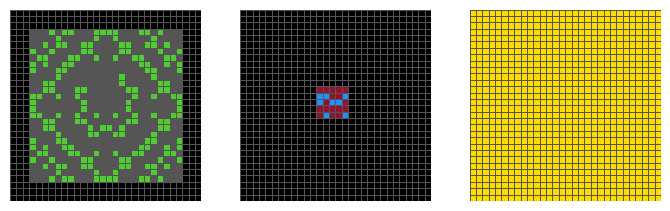

Validation: 100%|██████████| 42/42 [08:16<00:00, 11.83s/it]


Epoch 18/500, Loss: 7245.6044921875, Accuracy: 46.51150479954828%
Epoch 19/500


Validation:  98%|█████████▊| 41/42 [08:09<00:11, 11.93s/it]

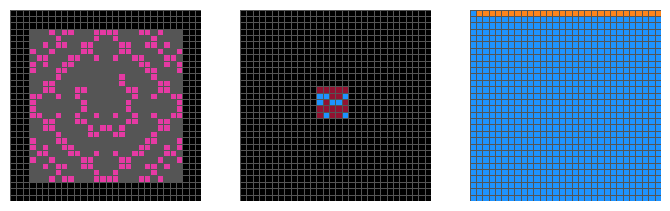

Validation: 100%|██████████| 42/42 [08:16<00:00, 11.83s/it]


Epoch 19/500, Loss: 7033.671875, Accuracy: 48.41014963297572%
Epoch 20/500


Validation:  98%|█████████▊| 41/42 [08:08<00:11, 11.94s/it]

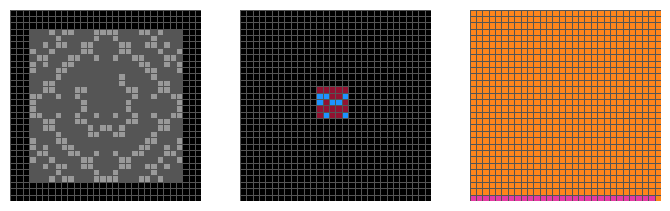

Validation: 100%|██████████| 42/42 [08:15<00:00, 11.81s/it]


Epoch 20/500, Loss: 7165.244140625, Accuracy: 49.30300677583286%
Epoch 21/500


Validation:  98%|█████████▊| 41/42 [08:09<00:11, 11.95s/it]

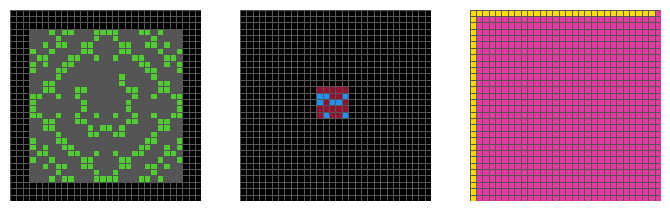

Validation: 100%|██████████| 42/42 [08:17<00:00, 11.83s/it]


Epoch 21/500, Loss: 6905.0517578125, Accuracy: 46.16036137775268%
Epoch 22/500


Validation:  98%|█████████▊| 41/42 [08:08<00:11, 11.92s/it]

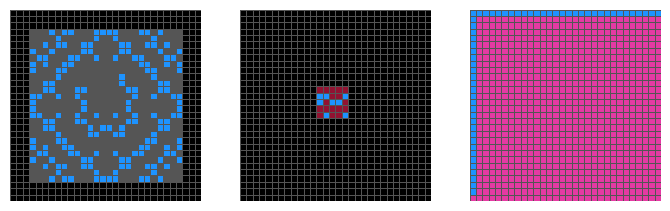

Validation: 100%|██████████| 42/42 [08:15<00:00, 11.81s/it]


Epoch 22/500, Loss: 7348.2255859375, Accuracy: 47.640810276679844%
Epoch 23/500


Validation:  98%|█████████▊| 41/42 [08:09<00:11, 11.94s/it]

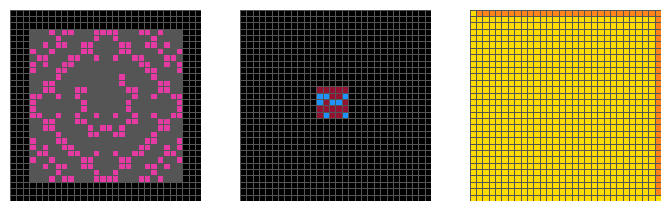

Validation: 100%|██████████| 42/42 [08:16<00:00, 11.83s/it]


Epoch 23/500, Loss: 6915.2724609375, Accuracy: 48.93421795595709%
Epoch 24/500


Validation:  98%|█████████▊| 41/42 [08:09<00:11, 11.94s/it]

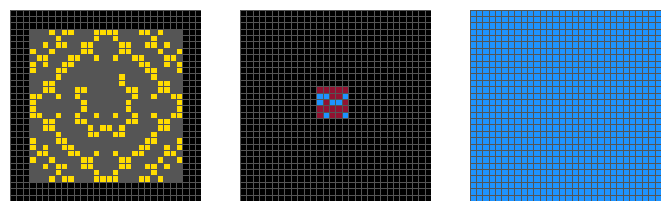

Validation: 100%|██████████| 42/42 [08:16<00:00, 11.82s/it]


Epoch 24/500, Loss: 6921.748046875, Accuracy: 49.12655279503105%
Epoch 25/500


Validation:  98%|█████████▊| 41/42 [08:09<00:11, 11.94s/it]

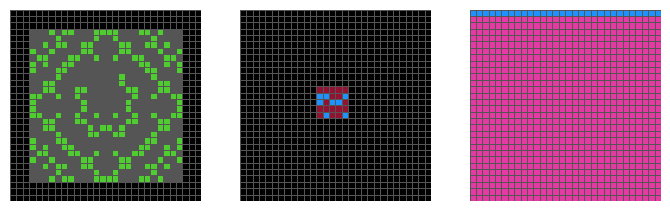

Validation: 100%|██████████| 42/42 [08:17<00:00, 11.84s/it]


Epoch 25/500, Loss: 6834.9296875, Accuracy: 47.7731507622812%
Epoch 26/500


Validation:  98%|█████████▊| 41/42 [08:11<00:11, 11.98s/it]

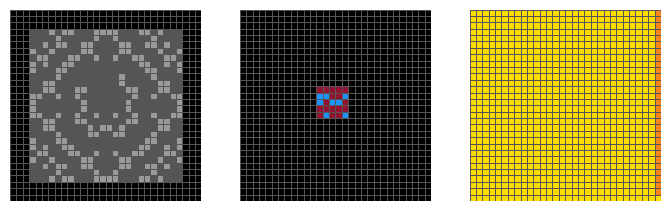

Validation: 100%|██████████| 42/42 [08:18<00:00, 11.86s/it]


Epoch 26/500, Loss: 6781.49951171875, Accuracy: 47.35671936758893%
Epoch 27/500


Validation:  98%|█████████▊| 41/42 [08:12<00:11, 11.95s/it]

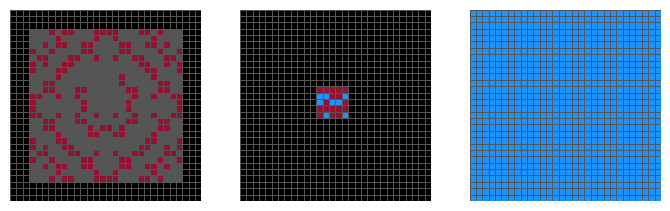

Validation: 100%|██████████| 42/42 [08:19<00:00, 11.89s/it]


Epoch 27/500, Loss: 7009.39208984375, Accuracy: 48.98009599096556%
Epoch 28/500


Validation:  98%|█████████▊| 41/42 [08:10<00:11, 11.96s/it]

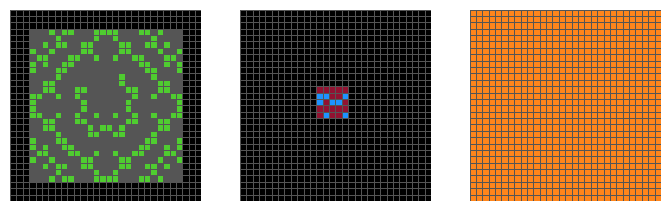

Validation: 100%|██████████| 42/42 [08:17<00:00, 11.85s/it]


Epoch 28/500, Loss: 7146.29248046875, Accuracy: 47.70433370976849%
Epoch 29/500


Validation:  98%|█████████▊| 41/42 [08:09<00:11, 11.94s/it]

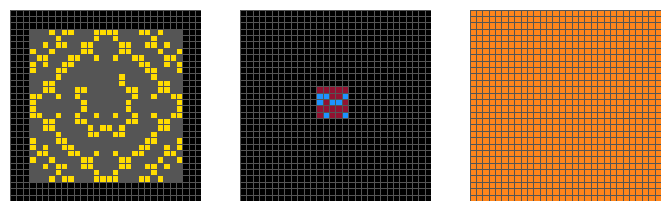

Validation: 100%|██████████| 42/42 [08:16<00:00, 11.83s/it]


Epoch 29/500, Loss: 7285.41357421875, Accuracy: 44.98517786561265%
Epoch 30/500


Validation:  98%|█████████▊| 41/42 [08:09<00:11, 11.95s/it]

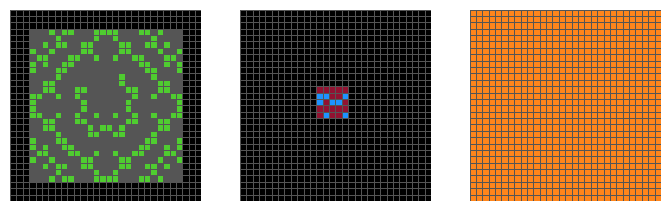

Validation: 100%|██████████| 42/42 [08:16<00:00, 11.82s/it]


Epoch 30/500, Loss: 6899.3125, Accuracy: 48.92539525691699%
Epoch 31/500


Validation:  98%|█████████▊| 41/42 [08:08<00:11, 11.91s/it]

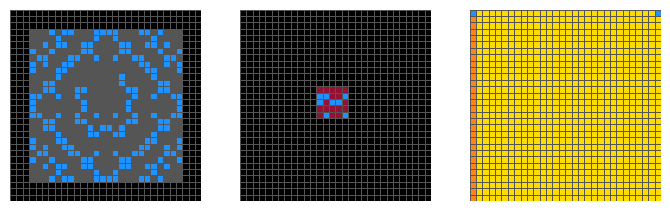

Validation: 100%|██████████| 42/42 [08:15<00:00, 11.80s/it]


Epoch 31/500, Loss: 7164.36279296875, Accuracy: 48.18781761716544%
Epoch 32/500


Training:  50%|█████     | 21/42 [03:57<03:58, 11.35s/it]

In [6]:
from bw_net_maml import BWNet_MAML
import torch
from torch.utils.data import DataLoader
from dataloader import ARC_Dataset
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
import gc


colors = ['#000000','#1E93FF','#F93C31','#4FCC30','#FFDC00',
          '#999999','#E53AA3','#FF851B','#87D8F1','#921231','#555555']
colormap = plt.matplotlib.colors.ListedColormap(colors)

def show_grid_side_by_side(*grids):
    num_grids = len(grids)
    fig, axes = plt.subplots(1, num_grids, figsize=(num_grids * 2.8, 2.8))

    if num_grids == 1:
        axes = [axes]  # 리스트로 변환하여 일관성 유지
    
    for ax, grid in zip(axes, grids):
        if grid.ndim == 4:
            grid = grid.squeeze()  # [1, 1, 30, 30] -> [30, 30]로 변환
        elif grid.ndim == 3:
            grid = grid[0]  # [1, 30, 30] -> [30, 30]로 변환
            
        ax.pcolormesh(grid, edgecolors=colors[-1], linewidth=0.5, cmap=colormap, vmin=0, vmax=10)
        ax.invert_yaxis()
        ax.set_aspect('equal')
        ax.axis('off')

    plt.show()

def criterion(y_pred, y):
    y = y.long().squeeze(1)
    weight = torch.ones(11).to(y.device, dtype=torch.float32)
    weight[0] = 0.0005  # 0은 무시
    ce = F.cross_entropy(y_pred, y, weight=weight)
    return ce

train_challenge = './kaggle/input/arc-prize-2024/arc-agi_training_challenges.json'
train_solution = "./kaggle/input/arc-prize-2024/arc-agi_training_solutions.json"
eval_challenge = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json"
eval_solution = "./kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json"

kwargs = {
    'epochs': 500,
    'task_numbers': 10, #equal to the number of tasks
    'task_data_num': 1,
    'example_data_num': 20, #equal to inner model batch size
    'inner_lr': 0.01,
    'outer_lr': 0.001,
    'embed_size': 1,
}
model_args =  {
    "img_size": 30,
    "patch_size": 3,
    "in_channels": 1,
    "embed_dim": 256,
    "num_heads": 8,
    "num_layers": 8,
    "mlp_dim": 2048,
    "dropout": 0.1,
    "output_channels": 11,
}
# CUDA 사용 가능 여부 확인
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device = 'cuda' if torch.cuda.is_available() else device  
print(f'Using {device} device')



train_dataset = ARC_Dataset(train_challenge, train_solution)
train_loader = DataLoader(train_dataset, batch_size=kwargs['task_numbers'], shuffle=True)

eval_dataset = ARC_Dataset(train_challenge, train_solution)
eval_loader = DataLoader(eval_dataset, batch_size=kwargs['task_numbers'], shuffle=False)

# Outer Model 정의
outer_model =  VisionTransformer(**model_args).to(device)

outer_optimizer = optim.AdamW(outer_model.parameters(), lr=kwargs['outer_lr'])

# Training Loop
for epoch in range(kwargs['epochs']):
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}')
    total_loss = 0
    outer_model.train()
    
    for data in tqdm(train_loader, desc='Training'):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]

        task_losses = []
        for task_number in range(input_tensor.shape[0]):
            # Inner loop
            inner_model = deepcopy(outer_model)
            inner_optimizer = optim.AdamW(inner_model.parameters(), lr=kwargs['inner_lr'])

            for _ in range(kwargs['example_data_num']):  # 여러 번의 Inner Update 수행
                inner_model.train()
                prediction = inner_model(example_input[task_number])
                loss = criterion(prediction, example_output[task_number])

                inner_optimizer.zero_grad()
                loss.backward()
                inner_optimizer.step()
            
            # Inner loop가 끝난 후, outer_model의 손실 계산을 위해 inner_model의 파라미터를 사용
            inner_model.eval()
            task_prediction = inner_model(input_tensor[task_number])
            task_loss = criterion(task_prediction, output_tensor[task_number])
            task_losses.append(task_loss)
        
        # Outer loop에서 모든 task의 손실을 누적하여 업데이트
        meta_loss = torch.stack(task_losses).mean()  # 모든 task의 손실 평균
        outer_optimizer.zero_grad()
        meta_loss.backward()
        outer_optimizer.step()

        # 메모리 해제
        del meta_loss, task_losses
        gc.collect()
        torch.cuda.empty_cache()

    # Validation Loop
    outer_model.eval()
    validation_correct = 0
    validation_total_samples = 0
    total_loss = 0

    # torch.no_grad()를 여기서 사용하지 않음 (Inner loop에서 역전파를 수행해야 하므로)
    for batch_idx, data in enumerate(tqdm(eval_loader, desc='Validation')):
        input_tensor, output_tensor, example_input, example_output = [d.to(device) for d in data]

        # Inner loop (Fine-tuning) 및 Evaluation을 각각 한 번에 하나씩 수행
        for task_number in range(input_tensor.shape[0]):
            # Inner loop (Fine-tuning)
            inner_model = deepcopy(outer_model)
            inner_optimizer = optim.AdamW(inner_model.parameters(), lr=kwargs['inner_lr'])

            for _ in range(kwargs['example_data_num']):  # Inner loop에서 업데이트 수행
                inner_model.train()
                eval_prediction = inner_model(example_input[task_number])
                loss = criterion(eval_prediction, example_output[task_number])

                inner_optimizer.zero_grad()
                loss.backward()
                inner_optimizer.step()

            # torch.no_grad()를 평가 시점에만 사용 (여기서만 사용)
            with torch.no_grad():
                # Evaluation after fine-tuning
                inner_model.eval()
                task_input = input_tensor[task_number]
                task_output = output_tensor[task_number]
                task_prediction = inner_model(task_input)
                task_loss = criterion(task_prediction, task_output)
                total_loss += task_loss

                prediction_class = torch.argmax(task_prediction, dim=1, keepdim=True)

                # 정답이 0이 아닌 부분만 선택하여 정확도 계산
                mask = task_output != 0
                correct_predictions = (prediction_class == task_output) & mask
                validation_correct += correct_predictions.sum().item()
                validation_total_samples += mask.sum().item()  # 0이 아닌 부분만 계산

                # 시각화: 마지막 배치의 마지막 task에서만 실행
                if batch_idx == len(eval_loader) - 1 and task_number == input_tensor.shape[0] - 1:
                    show_grid_side_by_side(task_input.cpu(), task_output.cpu(), prediction_class.cpu())

            # 메모리 해제
            del inner_model, inner_optimizer, eval_prediction, task_input, task_output, task_prediction, mask, correct_predictions
            gc.collect()
            torch.cuda.empty_cache()

    accuracy = 100 * validation_correct / validation_total_samples if validation_total_samples > 0 else 0  # 정확도 계산
    print(f'Epoch {epoch+1}/{kwargs["epochs"]}, Loss: {total_loss.item()}, Accuracy: {accuracy}%')

    torch.cuda.empty_cache()
